## Using XGBoost for Time Series

In [1]:
import xgboost
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot
import warnings
warnings.filterwarnings('ignore')

## Time Series Data prepration

In [2]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
# input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
# forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
# put it all together
    agg = concat(cols, axis=1)
# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

- Train Test split

In [3]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

- Fitting the XGBoost Model

In [4]:
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
# transform list into array
    train = asarray(train)
# split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
# fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(trainX, trainy)
# make a one-step prediction
    yhat = model.predict(asarray([testX]))
    return yhat[0]

In [5]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
# split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
# step over each time-step in the test set
    for i in range(len(test)):
# split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
# fit model on history and make a prediction
        yhat = xgboost_forecast(history, testX)
# store forecast in list of predictions
        predictions.append(yhat)
# add actual observation to history for the next loop
        history.append(test[i])
# summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
# estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

- Loding the dataset

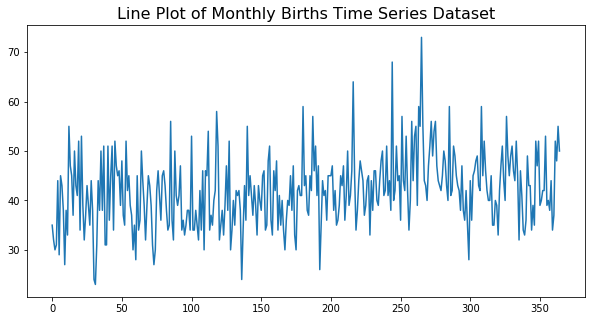

In [6]:
# load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv"
series = read_csv(url, header=0, index_col=0)
values = series.values
# plot dataset
pyplot.figure(figsize = (10,5))
pyplot.plot(values)
pyplot.title("Line Plot of Monthly Births Time Series Dataset", size = 16)
pyplot.show();

From the plot we can see that there is no trend or seasonality in the data.

## Obtaining Result

>expected=42.0, predicted=44.5
>expected=53.0, predicted=42.5
>expected=39.0, predicted=40.3
>expected=40.0, predicted=32.5
>expected=38.0, predicted=41.1
>expected=44.0, predicted=45.3
>expected=34.0, predicted=40.2
>expected=37.0, predicted=35.0
>expected=52.0, predicted=32.5
>expected=48.0, predicted=41.4
>expected=55.0, predicted=46.6
>expected=50.0, predicted=47.2
MAE: 5.957


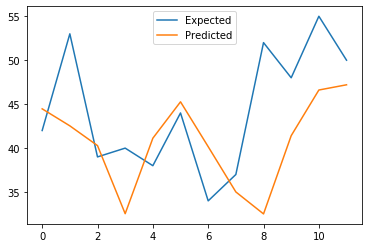

In [7]:
 # transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

We can see that the model performs better than a persistence model, achieving a MAE of about 5.9 births, compared to 6.7 births.


- Predicting one_step beyond the dataset

In [8]:
# transform the time series data into supervised learning
train = series_to_supervised(values, n_in=6)
# split into input and output columns
trainX, trainy = train[:, :-1], train[:, -1]

In [9]:
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(trainX, trainy)
# construct an input for a new preduction
row = values[-6:].flatten()
# make a one-step prediction
yhat = model.predict(asarray([row]))
print('Input: %s, Predicted: %.3f' % (row, yhat[0]))

Input: [34 37 52 48 55 50], Predicted: 42.708


A new row of input is prepared using the last 6 months of known data and the next month beyond the end of the dataset is predicted.